In [21]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from regression import ridge_and_lasso, decision_trees, k_nearest_neighbors, linear_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


In [120]:
def read_data(filepath):
    data = pd.read_excel(filepath, sheet_name = "Data", headers = None)
    data.rename(columns=data.iloc[0], inplace = True)
    data = data[1:]
    data.rename(columns={ data.columns[1]: "tic" }, inplace = True)
    data.rename(columns={ data.columns[0]: "id" }, inplace = True)
    data = data.set_index('tic')


    inter = pd.read_excel(filepath, sheet_name = "Int", headers = None)
    inter.rename(columns=inter.iloc[1], inplace = True)
    inter = inter[2:]
    inter.rename(columns={ inter.columns[1]: "tic" }, inplace = True)
    inter = inter.set_index('tic')
    inter.rename(columns={ inter.columns[0]: "id" }, inplace = True)
    inter['id'] = inter.id.astype(int)
    
    final = pd.read_excel(filepath, sheet_name = "Fnl", headers = None)
    final.columns = ['id', 'tic', 'MktCap', 'Shares', 'AvgV', 'r182', 'r364', 'PS+1', 'PS',	'PS-1']
    final = final[3:]
    final['id'] = final.id.astype(int)
    final = final.set_index('tic')

    descr = pd.read_excel(filepath, sheet_name = "Descr", headers = None)
    descr.columns = ['tic', 'Sector', 'Industry', 'Employees']
    del descr['Industry'], descr['Employees']
    descr = descr.set_index('tic')


    combined = pd.read_excel(filepath, sheet_name = "Data", headers = None)
    combined.rename(columns=combined.iloc[0], inplace = True)
    combined = combined[1:]
    combined.rename(columns={combined.columns[1]: "tic" }, inplace = True)
    combined.rename(columns={combined.columns[0]: "id" }, inplace = True)
    combined = combined.set_index('tic')
    del combined['Sector']

    combined = pd.concat([combined, inter], axis=1)

    return data, inter, combined, final, descr

In [121]:
filepath = "../TestData.1.xlsx"

data, inter, combined, final, descr = read_data(filepath)

In [122]:
combined

,id,S t+1,S t,St-1,St-2,St-3,St-4,St-5,GPt-1,GPt-2,...,Growth_GM,Growth_EBITM,Growth_PBTM,Growth_EBITDAM,Growth_NM,Growth_OCFM,Projections_St+1,Projections_St,Projections_SGrt+1,Sector
tic,,,,,,,,,,,,,,,,,,,,,
A,1,5620000,5200000,5160000,4910000,4470000,4200000,4040000,2790000,2680000,...,0.0410448,-463.5,-0.0285412,0.0446429,2.38608,-0.0642202,5620000,5200000,0.0807692,Healthcare
AA,2,9470000,8780000,10500000,13520000,11780000,9330000,11220000,1200000,2690000,...,-0.553903,-1.61952,-1.26871,-0.488889,-5.52,0.53125,9470000,8780000,0.0785877,Basic Materials
AAL,3,29770000,17460000,45770000,44540000,42620000,40180000,40990000,11420000,11020000,...,0.0362976,0.204724,0.202128,0.0730838,0.198582,0.082153,29770000,17460000,0.70504,Industrials
AAN,4,4450000,4120000,3950000,3830000,3380000,3210000,3180000,1730000,1810000,...,-0.0441989,-0.623742,-0.632078,0.092776,-0.839611,0.238626,4450000,4120000,0.0800971,Industrials
AAOI,5,259990,219910,190870,267470,382330,260710,189900,45700,87270,...,-0.476338,NaN,4.2546,-2.30639,29.7209,-1,259990,219910,0.182256,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNTL,1521,NaN,NaN,0,14,0,0,0,-111,0,...,NaN,NaN,0.97866,0.969237,1.16706,0.614021,NaN,NaN,NaN,Healthcare
ZSAN,1522,39040,2640,0,0,0,0,313,-1520,-764,...,0.989529,-1,0.0630656,0.0460411,0.0630656,0.162431,39040,2640,13.7879,Healthcare
ZTS,1523,6760000,6180000,6260000,5830000,5310000,4890000,4770000,4110000,3800000,...,0.0815789,0.0874317,0.0650888,0.109589,0.048951,0.00558659,6760000,6180000,0.0938511,Healthcare


## Independent Variables

In [24]:
data

,id,Sector,S t+1,S t,St-1,St-2,St-3,St-4,St-5,GPt-1,...,LTDt-5,TEQt-1,TEQt-2,TEQt-3,TEQt-4,TEQt-5,VarT,VarT+1,Srpr1,Srpr4
tic,,,,,,,,,,,,,,,,,,,,,
A,1,Healthcare,5620000,5200000,5160000,4910000,4470000,4200000,4040000,2790000,...,1660000,4750000,4570000,4830000,4240000,4170000,0.048,0.046,0.164,0.067
AA,2,Basic Materials,9470000,8780000,10500000,13520000,11780000,9330000,11220000,1200000,...,207000,4110000,5620000,4520000,5650000,9440000,0.131,0.213,0.042,0.056
AAL,3,Industrials,29770000,17460000,45770000,44540000,42620000,40180000,40990000,11420000,...,18330000,-118000,-169000,-780000,3790000,5640000,0.32,0.514,-0.016,-0.031
AAN,4,Industrials,4450000,4120000,3950000,3830000,3380000,3210000,3180000,1730000,...,450510,1740000,1760000,1730000,1480000,1370000,0.019,0.085,0.513,0.142
AAOI,5,Technology,259990,219910,190870,267470,382330,260710,189900,45700,...,34000,273790,329090,333280,227380,165400,0.153,0.191,-0.158,0.183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNTL,1521,Healthcare,NaN,NaN,0,14,0,0,0,-111,...,0,-80110,24770,NaN,NaN,NaN,NaN,NaN,-0.56,NaN
ZSAN,1522,Healthcare,39040,2640,0,0,0,0,313,-1520,...,11910,9390,18710,7050,4490,26500,NaN,0.681,0,0.034
ZTS,1523,Healthcare,6760000,6180000,6260000,5830000,5310000,4890000,4770000,4110000,...,4460000,2710000,2190000,1770000,1490000,1070000,0.065,0.089,0.105,0.079


## Intermediate Variables - percentage change, ratio

In [25]:
inter


,id,Margin_GM,Margin_EBITM,Margin_PBTM,Margin_EBITDAM,Margin_NM,Margin_OCFM,Growth_GM,Growth_EBITM,Growth_PBTM,Growth_EBITDAM,Growth_NM,Growth_OCFM,Projections_St+1,Projections_St,Projections_SGrt+1,Sector
tic,,,,,,,,,,,,,,,,,
A,1,0.540698,0.179264,0.178101,0.226744,0.207364,0.197674,0.0410448,-463.5,-0.0285412,0.0446429,2.38608,-0.0642202,5620000,5200000,0.0807692,Healthcare
AA,2,0.114286,0.029619,-0.0417143,0.153333,-0.107619,0.0653333,-0.553903,-1.61952,-1.26871,-0.488889,-5.52,0.53125,9470000,8780000,0.0785877,Basic Materials
AAL,3,0.249508,0.066856,0.0493773,0.131527,0.0369237,0.0834608,0.0362976,0.204724,0.202128,0.0730838,0.198582,0.082153,29770000,17460000,0.70504,Industrials
AAN,4,0.437975,0.0254608,0.0234911,0.105889,0.00796709,0.11179,-0.0441989,-0.623742,-0.632078,0.092776,-0.839611,0.238626,4450000,4120000,0.0800971,Industrials
AAOI,5,0.23943,0,-0.269241,-0.129565,-0.346047,0,-0.476338,NaN,4.2546,-2.30639,29.7209,-1,259990,219910,0.182256,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNTL,1521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.97866,0.969237,1.16706,0.614021,NaN,NaN,NaN,Healthcare
ZSAN,1522,NaN,NaN,NaN,NaN,NaN,NaN,0.989529,-1,0.0630656,0.0460411,0.0630656,0.162431,39040,2640,13.7879,Healthcare
ZTS,1523,0.65655,0.317891,0.28754,0.388179,0.239617,0.28754,0.0815789,0.0874317,0.0650888,0.109589,0.048951,0.00558659,6760000,6180000,0.0938511,Healthcare


## Dependent Variables

In [26]:
final

,id,MktCap,Shares,AvgV,r182,r364,PS+1,PS,PS-1
tic,,,,,,,,,
A,1,NaN,308310,1377.55,0.404493,0.269619,0,0,0
AA,2,180.161,622317,5656.56,0.641749,-0.458605,0.0190244,0.0205194,0.0171582
AAL,3,6229.88,508562,58304.2,-0.224821,-0.565233,0.209267,0.356809,0.136113
AAN,4,3845.84,67141,610.831,1.36574,-0.0879442,0.864233,0.933455,0.973629
AAOI,5,255.98,22774,704.229,0.404027,-0.105983,0.984575,1.16402,1.34112
...,...,...,...,...,...,...,...,...,...
ZNTL,1521,1336.9,40003,128.917,NaN,NaN,NaN,NaN,NaN
ZSAN,1522,127.498,79686,5378.9,1.86207,-0.0177515,3.26582,48.2945,NaN
ZTS,1523,77201.5,475145,1519.18,0.472415,0.276887,11.4203,12.4922,12.3325


## Find Correlation btw Intermediate Variables and Final Values

In [27]:
input_variables = inter.columns.to_list()[1:]

In [28]:
output_var = 'r182'
analysis = pd.DataFrame()

# dropping duplicates from final data
final = final[~final.index.duplicated(keep='first')]

inter_tics = list(set(inter.index.tolist()))
final_tics = list(set(final.index.tolist()))

print('Total unique companies : ', len(final_tics))
print('Output variable in consideration: ', output_var)

analysis['output'] = final.loc[final_tics][output_var]

for inter_var in input_variables:
    if inter_var == "Sector":
        continue
    print("Input variable: ", inter_var)
    analysis[inter_var] = inter.loc[final_tics][inter_var]
    analysis = analysis.dropna()
    print("Companies with valid intermediate, final variables: ", analysis.shape[0])
    corr_spearman, _ = stats.spearmanr(analysis['output'], analysis[inter_var])
    corr_pearson, _ = stats.pearsonr(analysis['output'], analysis[inter_var])
    print("Spearman correlation {}, Pearson correlation {}".format(corr_spearman, corr_pearson))
    print()


Total unique companies :  1525
Output variable in consideration:  r182
Input variable:  Margin_GM
Companies with valid intermediate, final variables:  1285
Spearman correlation -0.054406037958595534, Pearson correlation -0.05338362326608373

Input variable:  Margin_EBITM
Companies with valid intermediate, final variables:  1285
Spearman correlation -0.08106283758649142, Pearson correlation -0.01932049087923273

Input variable:  Margin_PBTM
Companies with valid intermediate, final variables:  1285
Spearman correlation -0.0650529901284602, Pearson correlation -0.032415394918071216

Input variable:  Margin_EBITDAM
Companies with valid intermediate, final variables:  1285
Spearman correlation -0.09244286374394181, Pearson correlation -0.028698629259702617

Input variable:  Margin_NM
Companies with valid intermediate, final variables:  1285
Spearman correlation -0.062070990526351635, Pearson correlation -0.03296429734502565

Input variable:  Margin_OCFM
Companies with valid intermediate, fi

## Sample Analysis

In [29]:
analysis

,output,Margin_GM,Margin_EBITM,Margin_PBTM,Margin_EBITDAM,Margin_NM,Margin_OCFM,Growth_GM,Growth_EBITM,Growth_PBTM,Growth_EBITDAM,Growth_NM,Growth_OCFM,Projections_St+1,Projections_St,Projections_SGrt+1
tic,,,,,,,,,,,,,,,,
IRWD,-0.0715686,0.931257,0.215144,0.137578,0.286221,0.137578,0.05315,0.32141,-1.63808,-1.30358,-42.01,-1.30358,-1.32125,407790,372780,0.093916
RRTS,-0.666183,0.123649,-0.195357,-0.18627,-0.0371676,-0.184292,-0.0524757,-0.33736,1.21629,0.96454,-6.40991,1.05882,-18.3667,557100,538700,0.0341563
PRTY,4.8,0.355319,-0.202472,-0.227302,0.083834,-0.226596,0.0185915,-0.147037,-2.74898,-4.30545,-0.447935,-5.32014,-0.571078,2080000,1830000,0.136612
STZ,0.47358,0.517986,0.245803,-0.113333,0.383693,-0.00141487,0.305755,0.0536585,-0.173387,-1.22776,0.0322581,-1.00343,0.133333,8150000,7830000,0.0408685
EGLE,0.190476,0.135509,0.00352281,-0.0742185,0.197996,-0.0742185,0.120254,-0.460439,-0.97246,-2.72633,-0.22803,-2.72633,-0.226743,225190,192580,0.169332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GPS,0.842984,0.374237,0.0214286,0.0322344,0.0958486,0.0214286,0.0860806,-0.0285261,-0.74,-0.6,-0.17801,-0.649,0.0217391,14950000,13100000,0.141221
NAT,0.1,0.143276,0,-0.0324065,0.30244,-0.0326272,0.166635,-3.65789,-1,-0.882595,2.10787,-0.891407,-4.34557,265430,280830,-0.0548374
NXPI,0.413387,0.359234,0.0681306,0.0327703,0.46509,0.0273649,0.266892,-0.0617647,-0.0304487,-0.877731,-0.00481928,-0.890045,-0.457666,8780000,7730000,0.135834


## Correlation Matrix

In [30]:
analysis = analysis.astype(np.float64)
corrMatrix = analysis.corr()

corrMatrix

,output,Margin_GM,Margin_EBITM,Margin_PBTM,Margin_EBITDAM,Margin_NM,Margin_OCFM,Growth_GM,Growth_EBITM,Growth_PBTM,Growth_EBITDAM,Growth_NM,Growth_OCFM,Projections_St+1,Projections_St,Projections_SGrt+1
output,1.000000,-0.003254,-0.025126,-0.224906,-0.227078,-0.224398,-0.227638,0.025714,-0.011409,-0.046937,0.017102,-0.018974,0.000950,-0.022901,-0.023568,0.113048
Margin_GM,-0.003254,1.000000,0.095438,0.134485,0.136117,0.134307,0.167526,-0.017661,0.002960,-0.010492,-0.031089,0.007954,-0.008183,0.002885,0.002705,-0.097462
Margin_EBITM,-0.025126,0.095438,1.000000,0.107531,0.066232,0.107095,0.075345,0.017321,0.005874,-0.004857,-0.014735,-0.020993,0.004156,0.021577,0.021648,-0.370622
Margin_PBTM,-0.224906,0.134485,0.107531,1.000000,0.998635,0.999995,0.997813,0.001226,-0.000703,-0.003232,-0.026683,-0.012742,0.001653,0.010162,0.010269,-0.114329
Margin_EBITDAM,-0.227078,0.136117,0.066232,0.998635,1.000000,0.998638,0.999194,0.001273,-0.000504,-0.003000,-0.026506,-0.011874,0.001618,0.009931,0.010029,-0.102480
Margin_NM,-0.224398,0.134307,0.107095,0.999995,0.998638,1.000000,0.997804,0.000871,-0.000704,-0.003327,-0.026657,-0.012851,0.001661,0.010102,0.010209,-0.113498
Margin_OCFM,-0.227638,0.167526,0.075345,0.997813,0.999194,0.997804,1.000000,0.002335,-0.000322,-0.003089,-0.027057,-0.012222,0.001666,0.010716,0.010808,-0.115474
Growth_GM,0.025714,-0.017661,0.017321,0.001226,0.001273,0.000871,0.002335,1.000000,-0.001348,-0.002366,-0.028956,-0.006989,-0.001777,0.006536,0.006563,-0.053508
Growth_EBITM,-0.011409,0.002960,0.005874,-0.000703,-0.000504,-0.000704,-0.000322,-0.001348,1.000000,-0.002554,-0.007371,-0.006394,0.001031,0.006222,0.006122,0.006230
Growth_PBTM,-0.046937,-0.010492,-0.004857,-0.003232,-0.003000,-0.003327,-0.003089,-0.002366,-0.002554,1.000000,0.010371,0.031616,-0.000727,0.000465,0.000469,0.003517


## Plotting Heatmap

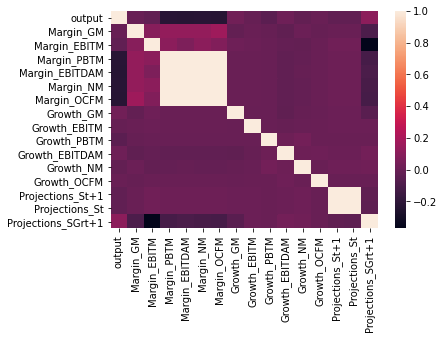

In [31]:
sn.heatmap(corrMatrix, xticklabels=corrMatrix.columns,
        yticklabels=corrMatrix.columns)
plt.show()

### Correlations based on company sector

In [32]:
# Fill in Sector
analysis = analysis.join(descr, on='tic', how='left')
analysis = analysis.dropna()

Basic Materials (76, 17)


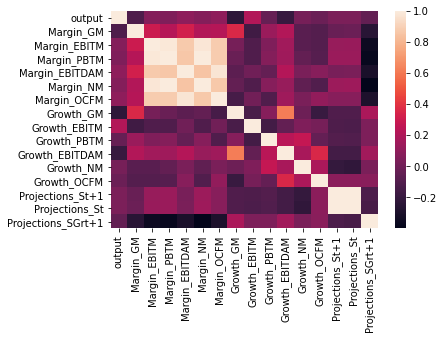

Communication Services (13, 17)


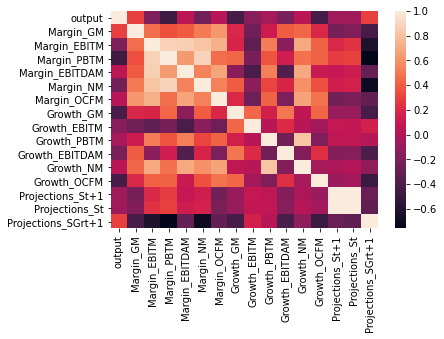

Consumer Cyclical (161, 17)


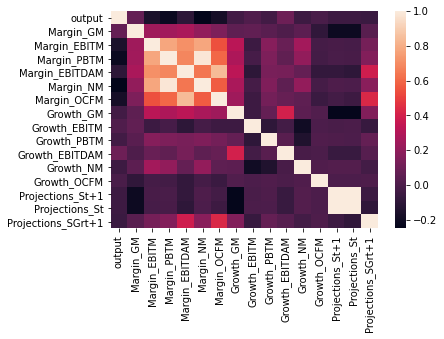

Consumer Defensive (68, 17)


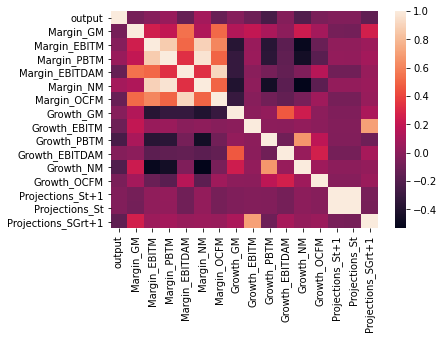

Energy (23, 17)


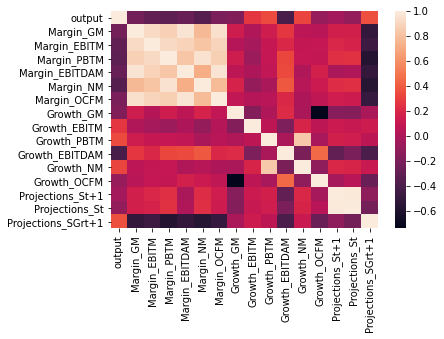

Financial Services (2, 17)


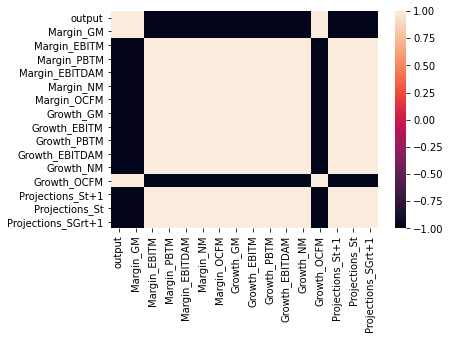

Healthcare (152, 17)


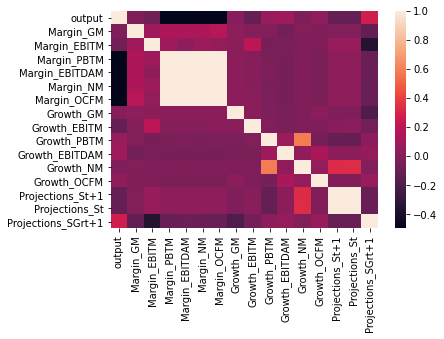

Industrials (128, 17)


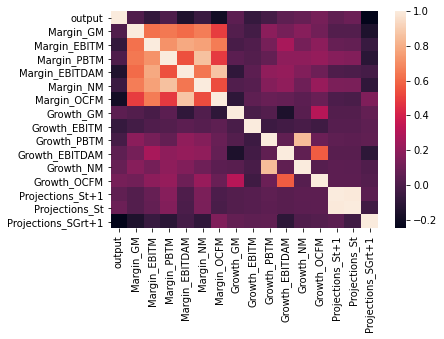

Technology (76, 17)


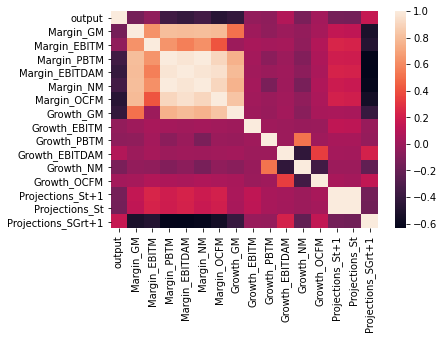

In [33]:

groups = analysis.groupby('Sector')
for sector, df in groups:
    print(sector, df.shape)
    del df['Sector']
    group_analysis = df.astype(np.float64)
    corrMatrix = group_analysis.corr()
    sn.heatmap(corrMatrix, xticklabels=corrMatrix.columns,
        yticklabels=corrMatrix.columns)
    plt.show()  

## Regression Models

In [34]:
# Compute MAE
def compute_error(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

# Compute MSE
def compute_MSE(y, y_hat):
    # mean squared error
    return np.mean(np.power(y - y_hat, 2))

In [59]:
def prepare_data(X, Y, use_sector=True):
    X = X.reset_index()
    del X['tic'], X['id']
    Y = Y.reset_index()
    del Y['tic']
    
    ml_data = pd.DataFrame(X)
    ml_data['output'] = pd.DataFrame(Y)

    print('Original data shape: ', ml_data.shape)

    # del columns with all NAN
    ml_data = ml_data.dropna(axis=1, how='all')

    # sector can't be aggregated, drop if NAN
    ml_data = ml_data[pd.notnull(ml_data['Sector'])]
    print('Data after removing NAN sector: ', ml_data.shape)
    
    if use_sector:
        print("Convert ordinal Sector into one-hot vectors")
        ml_data = pd.concat([ml_data,pd.get_dummies(ml_data['Sector'], prefix='Sector',dummy_na=False)],axis=1).drop(['Sector'],axis=1)
    else:
        del ml_data['Sector']
        
    # replace with mean values
    print("Replacing empty cells with column means")
    for col in ml_data.columns.to_list():
        if col == 'Sector':
            continue
        ml_data[col].fillna(ml_data[col].mean(), inplace=True)

    # del rows with any NAN 
    # ml_data = ml_data.dropna()

    # NEVER standardize before train/test split
    # ml_data_new = preprocessing.MinMaxScaler().fit_transform(ml_data)
    # ml_data = pd.DataFrame(ml_data_new, columns = ml_data.columns)

    print("Final Data: ", ml_data.shape)

    _X = pd.DataFrame(ml_data)
    _Y = _X["output"]
    del _X['output']

    
    
    train_x, test_x, train_y, test_y = train_test_split(_X, _Y, shuffle=True, test_size=0.3, random_state=15)

    return train_x, train_y, test_x, test_y

### Prepare Data

In [151]:
input_data = 'combined' # data, inter, combined
predict = 'r182' # r182, r364
metrics = ['mae', 'mse']
models = ['dt', 'knn', 'lm', 'lr']
use_sector = True # True, False

if input_data == 'data':
    train_x_df, train_y_df, test_x_df, test_y_df = prepare_data(data, final[predict], use_sector=use_sector)
elif input_data == 'inter':
    train_x_df, train_y_df, test_x_df, test_y_df = prepare_data(inter, final[predict], use_sector=use_sector)
elif input_data == 'combined':
    train_x_df, train_y_df, test_x_df, test_y_df = prepare_data(combined, final[predict], use_sector=use_sector)
# Requires numpy array for cross-validation in regression.py
train_x = train_x_df.to_numpy()
test_x = test_x_df.to_numpy()
train_y = train_y_df.to_numpy()
test_y = test_y_df.to_numpy()

print('Train=', train_x.shape)
print('Test=', test_x.shape)

# normalize and scale data attributes
# use only train_x for fitting
# don't normalize, scale output variable
scaler = preprocessing.MinMaxScaler().fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

Original data shape:  (1525, 102)
Data after removing NAN sector:  (1216, 102)
Convert ordinal Sector into one-hot vectors
Replacing empty cells with column means
Final Data:  (1216, 111)
Train= (851, 110)
Test= (365, 110)


In [152]:
train_x_df

,S t+1,S t,St-1,St-2,St-3,St-4,St-5,GPt-1,GPt-2,GPt-3,...,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology
76,227200.0,4.280000e+03,5800,10330,10740,3240,10640,0,0,0,...,0,0,0,0,0,0,1,0,0,0
253,2380000.0,2.230000e+06,3620000,3300000,2820000,2720000,2550000,1040000,910300,851400,...,0,0,0,0,0,0,0,1,0,0
13,8280000.0,6.890000e+06,7210000,6870000,6460000,6530000,6590000,1130000,1070000,1020000,...,0,0,1,0,0,0,0,0,0,0
33,101290.0,7.667000e+04,54640,34050,571,572,1920,52170,31950,-640,...,0,0,0,0,0,0,1,0,0,0
1027,1020000.0,9.896500e+05,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,21280000.0,1.976000e+07,21340000,21410000,21530000,21610000,20860000,3340000,3230000,3200000,...,0,0,1,0,0,0,0,0,0,0
840,69110.0,6.455247e+06,165,428,0,0,0,0,0,-28,...,0,0,0,0,0,0,1,0,0,0
196,42700.0,2.670000e+04,31270,21110,12030,6130,4140,23250,15920,9570,...,0,0,0,0,0,0,1,0,0,0
478,231860.0,1.963800e+05,270130,261250,252990,274430,284180,113520,124820,86940,...,0,1,0,0,0,0,0,0,0,0


### Feature Selection

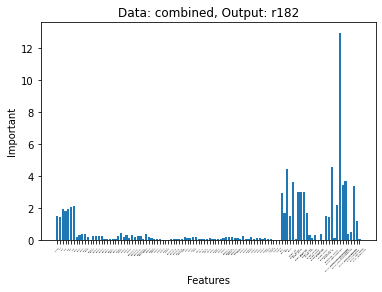

In [153]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    X_train = X_train.astype(np.float64)
    y_train = y_train.astype(np.float64)
    X_test = X_test.astype(np.float64)
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs


# feature selection
X_train_fs, X_test_fs, fs = select_features(train_x_df, train_y_df, test_x_df)

# what are scores for the features
# for i in range(len(fs.scores_)):
# 	print('Feature %d: %f' % (i, fs.scores_[i]))

# plot the scores
columns = train_x_df.columns.to_list()
pyplot.xticks(rotation = (45), fontsize = 2)
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_, tick_label=columns)
pyplot.xlabel("Features")
pyplot.ylabel("Important")
pyplot.title("Data: " + input_data + ", Output: " + predict)
pyplot.show()

### Regression Model

Running decision tree regressor for data type: A
Mean error for data A and hyperparameter 3: 0.4578
--- 1489 milli-seconds ---
Mean error for data A and hyperparameter 6: 0.5030
--- 2204 milli-seconds ---
Mean error for data A and hyperparameter 9: 0.5504
--- 2736 milli-seconds ---
Mean error for data A and hyperparameter 12: 0.5640
--- 3003 milli-seconds ---
Mean error for data A and hyperparameter 15: 0.6326
--- 3207 milli-seconds ---
Mean error for data A and hyperparameter 20: 0.6390
--- 3580 milli-seconds ---
Mean error for data A and hyperparameter 25: 0.6506
--- 3715 milli-seconds ---
Mean error for data A and hyperparameter 30: 0.6590
--- 3633 milli-seconds ---
Mean error for data A and hyperparameter 35: 0.6594
--- 3626 milli-seconds ---
Mean error for data A and hyperparameter 40: 0.6576
--- 3619 milli-seconds ---
After cross-val, best depth for data A is 3 with mean Error: 0.4578
Training model on full data
MAE on test set: 0.4557
MSE on test set: 0.5844
Running k-nearest ne

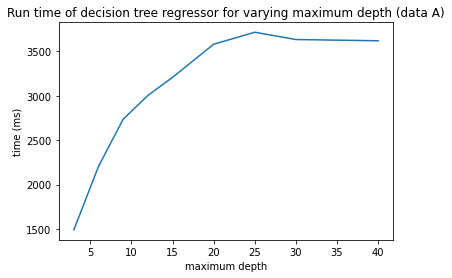

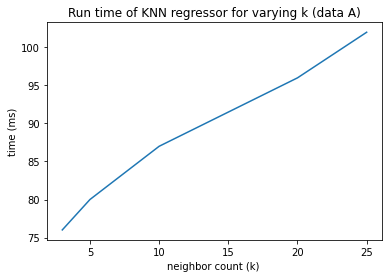

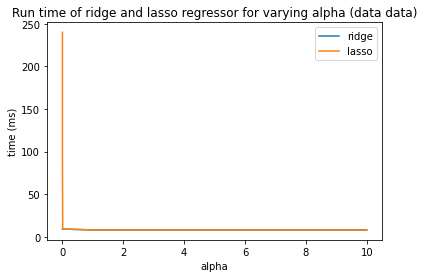

In [154]:
for model in models:
    if model == 'dt':
        predicted_y, dt_model = decision_trees('A', train_x, train_y, test_x)
    elif model =='knn':
        predicted_y, knn_model = k_nearest_neighbors('A', train_x, train_y, test_x)
    elif model =='lr':
        predicted_y, lr_model = linear_regression('A', train_x, train_y, test_x)
    elif model == 'lm':
        predicted_y, lm_model = ridge_and_lasso('data', train_x, train_y, test_x)

    for metric in metrics:
        if metric == 'mae':
            print('MAE on test set: {:0.4f}'.format(compute_error(predicted_y, test_y)))
        elif metric == 'mse':
            print('MSE on test set: {:0.4f}'.format(compute_MSE(predicted_y, test_y)))

In [155]:
# print('Printing Predictions')
# for y_hat, y in zip(predicted_y, test_y):
#     print(y, y_hat)

### Feature Importance based on learned regressor

In [156]:
for model in [dt_model, lr_model, lm_model]:
    print('\nModel : ', model)
    
    model_select = SelectFromModel(model, prefit=True)
    train_x_df_new = model_select.transform(train_x_df)
    print(train_x_df.shape, train_x_df_new.shape)

    feature_idx = model_select.get_support()
    feature_name = train_x_df.columns[feature_idx]
    print("Important Features: " ,feature_name)


Model :  DecisionTreeRegressor(criterion='mae', max_depth=3)
(851, 110) (851, 7)
Important Features:  Index(['GPt-1', 'SGAt-4', 'PBTt-4', 'Srpr1', 'Margin_EBITM', 'Margin_NM',
       'Sector_Consumer Cyclical'],
      dtype='object')

Model :  LinearRegression()
(851, 110) (851, 10)
Important Features:  Index(['Sector_Basic Materials', 'Sector_Communication Services',
       'Sector_Consumer Cyclical', 'Sector_Consumer Defensive',
       'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare',
       'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology'],
      dtype='object')

Model :  Ridge(alpha=10)
(851, 110) (851, 31)
Important Features:  Index(['S t+1', 'St-1', 'St-2', 'St-3', 'St-4', 'St-5', 'VarT', 'VarT+1',
       'Srpr1', 'Srpr4', 'Margin_GM', 'Margin_EBITM', 'Margin_PBTM',
       'Margin_EBITDAM', 'Margin_NM', 'Margin_OCFM', 'Growth_GM',
       'Growth_EBITM', 'Growth_PBTM', 'Growth_NM', 'Projections_St+1',
       'Projections_SGrt+1', 'Sector_Basic Mate